# Trabajo Practico 1: Bayes Ingenuo

### Estudiantes:
1. Sophia Contreras
2. Yoksan Varela
3. Mauro Viquez

In [1]:
# Librerias usadas en el codigo
import torch
import numpy as np
import pandas as pd
import scipy.stats as stats
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Para remover Warnings
import warnings
warnings.filterwarnings("ignore")

# Para Pruebas unitarias
import ipytest
ipytest.autoconfig()

import sys
np.set_printoptions(threshold=sys.maxsize)

### Funciones Generales

In [2]:
def load_cifar10_dataset(is_train = True):
    """Funcion para cargar CIFAR10 dataset, tomada del notebook BayesianModel_CIFAR_base.ipynb provisto en el curso.

    Args:
        is_train (bool, optional): Especifica si el modelo se esta entrenando. Defaults to True.

    Returns:
        Tensor: Retorna los tensores con sus respectivos labels
    """
    # Define a transformation to convert images to grayscale
    transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
    ])
    cifar_trainset = datasets.CIFAR10(root='./data', train = is_train, download = True, transform = transforms_1)
  

    # Initialize an empty list to store batches
    all_data = []
    train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size = 64, shuffle=True)
    # Iterate over the train_loader to fetch all batches
    for batch in train_loader:
        images, _ = batch  # Extract images from the batch
        all_data.append(images)

    # Concatenate all batches into a single tensor along the batch dimension
    cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
    cifar_labels = torch.tensor(cifar_trainset.targets)
    print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
    print("cifar_labels ", cifar_labels.shape)
    return (cifar_trainset_tensor, cifar_labels)

## Pregunta 1: Implementacion de la clasificacion multi-clase de imagenes con Byes Ingenuo usando histogramas

### Pregunta 1.2.1: Crear funcion calcular_probabilidad_priori

In [3]:
def calcular_probabilidad_priori(labels):
    # Tamano del tensor de labels
    size = len(labels)

    # Leemos el label mas grande
    max_label = labels.max()

    # Contamos todos los labels o categorias en el arreglo
    count_labels = np.bincount(labels,minlength=max_label)

    # Calculamos la prioridad basandose en el tamano del tensor de labels
    prob_a_priori = count_labels/size

    return torch.tensor(prob_a_priori)

### Pregunta 1.2.1: Pruebas unitarias para la funcion calcular_probabilidad_priori:

In [4]:
%%ipytest

# Creando un arreglo de 25 con 9 categorias diferentes
test_tensor = torch.tensor([0,1,1,2,2,2,2,2,3,3,3,4,5,6,6,6,6,6,6,7,7,8,8,9,9])

# Por un calculo a mano podemos calcular que las probablidades de cada uno de los lables van a ser: 0.04, 0.08, 0.2, 0.12, 0.04, 0.04, 0.24, 0.08, 0.08 y 0.08
result_tensor = torch.tensor([0.0400, 0.0800, 0.2000, 0.1200, 0.0400, 0.0400, 0.2400, 0.0800, 0.0800, 0.0800], dtype=torch.float64)

def test_calcular_probabilidad_priori_all() -> None:
    # Primera prueba unitaria: Comparar todas las probabilidades con los valores conocidos anteriores
    prob_all = calcular_probabilidad_priori(test_tensor)
    comparison = torch.equal(result_tensor,prob_all)
    assert comparison == True

def test_calcular_probabilidad_priori_suma() -> None:
    prob_all = calcular_probabilidad_priori(test_tensor)
    # Segunda prueba unitaria: La suma de las todas las probabilidades de las categorias tiene que dar 1
    assert (prob_all.sum()) == 1

..                                                                                           [100%]
2 passed in 0.02s


### Pregunta 1.2.1: Enfoque basado en histogramas: Hypercubo de D x Z x K
Donde D es la densidad de probablidad para cada pixel (1024 en total), Z es la intensidad de cada pixel (de 0 a 255) y K es la categoria a la que pertenece (total de 10 categorias).

In [5]:
def create_probability_per_category(data,d,z):
    # Capturando la cantidad total de imagenes. La probabilidad de cada pixel la dicta este valor.
    imagenes_qty = data.shape[0]

    # Aplanando todos los tensores para convertirlos en 1D de D pixeles, y convirtiendo los datos en int64 (la funcion bincount de numpy necesita ese formato)
    tensor_flat = torch.flatten(data)
    tensor_flat = torch.tensor(tensor_flat,dtype=torch.int64)

    # Creando un tensor de # de imagenes x D pixeles
    reshaped_tensor = tensor_flat.reshape(imagenes_qty,d)

    # Haciendo la transpuesta para tener un tensor de D x # de imagenes
    transposed_tensor = np.transpose(reshaped_tensor)

    # Contando la intensidad de luz por pixel para los 255 niveles. Esto genera un tensor de D (cantidad de pixeles) x Z valores
    count_tensor = np.apply_along_axis(np.bincount, axis=1, arr=transposed_tensor, minlength = z)

    # Finalmente, se divide todo el tensor entre el numero de imagenes procesadas para obtener la densidad de probabilidad m condicionada por t; y se retorna
    count_tensor = torch.tensor(count_tensor,dtype=torch.float32)
    probabilty_tensor = count_tensor/imagenes_qty

    return torch.tensor(probabilty_tensor)

In [6]:
def create_density_hypercube(labels,data,k,d,z):
    # Creando un hypercubo en ceros con las dimensiones pre-establecidas
    hypercube = torch.zeros([k,d,z])

    for category in range(k):
        # Creando un tensor con los indices de todas las imagenes para la categoria actual
        index_list = torch.tensor(labels == category)

        # Creando un nuevo tensor con solo las imagenes que corresponden a la categoria actual
        indexed_images = torch.tensor(data[index_list])
        
        # Enviar a procesar el nuevo tensor y popular el hypercubo solo si tiene datos, si no, continuar con la siguiente categoria
        if(indexed_images.numel() != 0):
            # Finalmente se popula el hypercubo
            hypercube[category,:,:] = create_probability_per_category(indexed_images,d,z)
    
    return hypercube

#with open("hipercubo.csv", "w+") as file:
    # Converting the array to a string and writing to the file
    #file.write(str(dataset_densities))

### Pregunta 1.2.1: Funcion train_model_histogram
Esta debe retornar el dataset_densities, junto con el arreglo de probabilidades a priori para todas las clases.

In [7]:
def train_model_histogram(labels,data,k,d,z):
    # Creado el hypercubo K x D x Z
    dataset_densities = create_density_hypercube(labels,data,k,d,z)

    # Creando el arreglo de probabilidades a priori de las categorias
    prob_a_priori = calcular_probabilidad_priori(labels)
    
    return dataset_densities, prob_a_priori

### Pregunta 1.2.1: Pruebas unitarias para la funcion train_model_histogram:

In [8]:
%%ipytest

# Definiendo las dimensiones para ser usadas en las pruebas unitarias: Cuatro categorias, con data de 3x3 que generan arreglos de 9 unidades, 3 posibles valores para cada unidad
K = 3
D = 9
Z = 3

# Creando tensor de categorias para 6 set de datos
category_tensor = torch.tensor([0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data_tensor = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

# Creando tensor con las probabilidades de las categorias que son conocidas: 1/6, 2/6 y 3/6 y la probabilidad de que la categoria tengo un 1 en cualquier unidad
prob_category = torch.tensor([1/6, 2/6, 3/6], dtype=torch.float64)
prob_cat0 = torch.tensor([1,1,1,1,1,1,1,1,1], dtype=torch.int32)

def test_train_model_histogram_priori_all() -> None:
    # Primera prueba unitaria: Comparar todas las probabilidades a priori con los valores ya conocidos
    ut_dataset, ut_a_priori = train_model_histogram(category_tensor,data_tensor,K,D,Z)
    comparison = torch.equal(ut_a_priori,prob_category)
    assert comparison == True

def test_train_model_histogram_cat0_priority() -> None:
    # Segunda prueba unitaria: Para cualquier unidad de la categoria 0, la probablidad de que salga el valor 1 es 100%
    ut_dataset, ut_a_priori = train_model_histogram(category_tensor,data_tensor,K,D,Z)
    prob_cat0_meas = torch.tensor(ut_dataset[0,:,1],dtype=torch.int32)
    comparison = torch.equal(prob_cat0_meas,prob_cat0)
    assert comparison == True


..                                                                                           [100%]
2 passed in 0.03s


### Pregunta 1.2.1: Histogramas

In [9]:
# Creando el set de entrenamiento
set_tensor,set_labels = load_cifar10_dataset()

# Llamando la funcion
K = 10
D = 1024
Z = 256
train_dataset_dens, train_prob_a_priori = train_model_histogram(set_labels,set_tensor,K,D,Z)
print(train_dataset_dens.shape)
print(train_prob_a_priori)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])
torch.Size([10, 1024, 256])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], dtype=torch.float64)


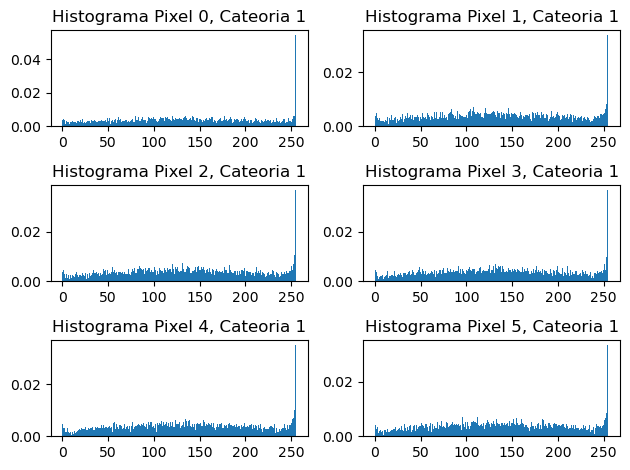

In [10]:
# Creando los histogramas para la categoria 1
fig1, ((hist1,hist2),(hist3,hist4),(hist5,hist6)) = plt.subplots(nrows=3,ncols=2)

# Ploteando los histogramas
hist1.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,0,:], histtype='bar')
hist1.set_title('Histograma Pixel 0, Cateoria 1')

hist2.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,1,:], histtype='bar')
hist2.set_title('Histograma Pixel 1, Cateoria 1')

hist3.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,2,:], histtype='bar')
hist3.set_title('Histograma Pixel 2, Cateoria 1')

hist4.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,3,:], histtype='bar')
hist4.set_title('Histograma Pixel 3, Cateoria 1')

hist5.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,4,:], histtype='bar')
hist5.set_title('Histograma Pixel 4, Cateoria 1')

hist6.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[1,5,:], histtype='bar')
hist6.set_title('Histograma Pixel 5, Cateoria 1')

fig1.tight_layout()
plt.show()

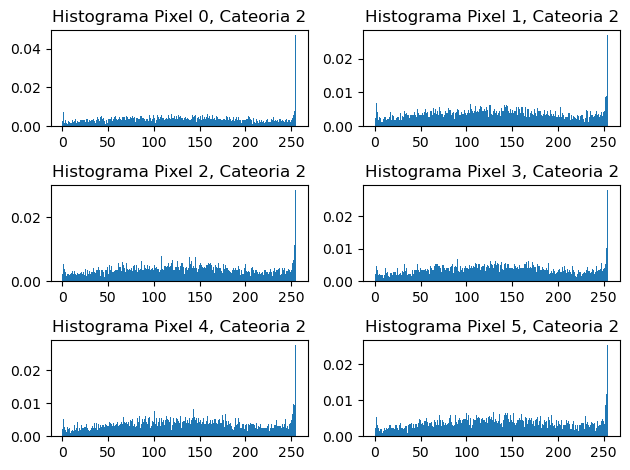

In [11]:
# Creando los histogramas para la categoria 2
fig2, ((hist1,hist2),(hist3,hist4),(hist5,hist6)) = plt.subplots(nrows=3,ncols=2)

# Normalizando las probablilidades entre 0 y 255 -> Para visualizacion de los histogramas solamente
cat2_pixels_norm = ((train_dataset_dens[2,:,:] - train_dataset_dens[2,:,:].min())/(train_dataset_dens[2,:,:].max() - train_dataset_dens[2,:,:].min()))*255

# Ploteando los histogramas
hist1.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,0,:], histtype='bar')
hist1.set_title('Histograma Pixel 0, Cateoria 2')

hist2.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,1,:], histtype='bar')
hist2.set_title('Histograma Pixel 1, Cateoria 2')

hist3.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,2,:], histtype='bar')
hist3.set_title('Histograma Pixel 2, Cateoria 2')

hist4.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,3,:], histtype='bar')
hist4.set_title('Histograma Pixel 3, Cateoria 2')

hist5.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,4,:], histtype='bar')
hist5.set_title('Histograma Pixel 4, Cateoria 2')

hist6.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[2,5,:], histtype='bar')
hist6.set_title('Histograma Pixel 5, Cateoria 2')

fig2.tight_layout()
plt.show()

### Pregunta 1.2.2: Funcion model_histogram_test

In [12]:
def model_histogram_test(input_torch, dataset_densities, labels_a_priori, num_classes = 10):
    # Haciendo flat el input_torch de entrada
    image_flat = torch.tensor(input_torch.flatten(),dtype=torch.int32)

    results = np.array([])

    for category in range(num_classes):
        # Creando un arreglo para seleccionar todas las filas y evaluandolas por los valores del input_torch flat, para cada categoria
        index_list = np.arange(0,len(dataset_densities[category,:,0]))
        tensor_prob_m_t = dataset_densities[category,index_list,image_flat]

        # Para Bayes ingenuo es necesario hacer una multiplicatoria, por lo que se aplica logaritmo natural negativo a los valores de las probabilidad para poder sumarlas
        # Nota: Probalidades iguales a 0 causan un -infinito. Se tienen que sustituir por un numero muy pequenno: 0.00001
        tensor_prob_m_t[tensor_prob_m_t == 0.0] = 0.00001
        tensor_ln_prob_mt = -torch.log(tensor_prob_m_t)
        
        # Se suman todos los valores para tener el score de la categoria para p(m|t=k)
        prob_mt = tensor_ln_prob_mt.sum()

        # Multiplicar la suma total por la probabilidad a priori del label correspondiente
        prob_t = labels_a_priori[category]
        prob_mt_k = prob_mt - torch.tensor(prob_t)

        # Agregar el resultado al arreglo de resultados
        results = np.append(results, prob_mt_k)

    # Determinando cual es la categoria correspondiente
    min_value = results.min()
    category_index = np.where(results == min_value)

    return category_index[0]

### Pregunta 1.2.2: Pruebas unitarias para la funcion model_histogram_test:

In [13]:
%%ipytest

# Utilizando la misma estructura de las pruebas unitarias anteriores
K = 3
D = 9
Z = 3

# Creando tensor de categorias para 6 set de datos
category_tensor = torch.tensor([0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data_tensor = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

ejemplo_dataset, ejemplo_a_priori = train_model_histogram(category_tensor,data_tensor,K,D,Z)

def test_model_histogram_testimage_1() -> None:
    # Primera prueba unitaria: Utilizando el tensor [0,2,0],[2,0,2],[0,2,0], el cual tiene que entregar como resultado que pertenece a la categoria #1
    test_image = torch.tensor([[0,2,0],[2,0,2],[0,2,0]])
    category = model_histogram_test(test_image, ejemplo_dataset, ejemplo_a_priori, K)
    assert category[0] == 1

def test_model_histogram_testimage_2() -> None:
    # Segunda prueba unitaria: Utilizando el tensor [1,2,1],[1,0,0],[2,2,1], el cual tiene que entregar como resultado que pertenece a la categoria #2 por su semejanza a una de las unidades de entrenamiento
    test_image = torch.tensor([[1,2,1],[1,0,0],[2,2,1]])
    category = model_histogram_test(test_image, ejemplo_dataset, ejemplo_a_priori, K)
    assert category[0] == 2

..                                                                                           [100%]
2 passed in 0.03s


### Pregunta 1.2.3: Funcion model_batch_histogram_test

In [14]:
def model_batch_histogram_test(test_set, test_labels, dataset_densities, p_t_tensor):
    
    y_predict = np.array([])
    
    for category in range(len(test_labels)):
        category_predicted = model_histogram_test(test_set[category], dataset_densities, p_t_tensor, len(p_t_tensor))
        y_predict = np.append(y_predict,category_predicted[0])
    
    y_real_tensor = torch.tensor(test_labels,dtype=torch.int32)
    y_predict_tensor = torch.tensor(y_predict,dtype=torch.int32)

    # Calculando el Accuracy usando la funcion de scikit-learn
    accuracy = accuracy_score(y_real_tensor,y_predict_tensor)
    return accuracy

### Pregunta 1.2.3: Pruebas unitarias para la funcion model_batch_histogram_test:

In [15]:
%%ipytest

# Utilizando la misma estructura de las pruebas unitarias anteriores
K = 3
D = 9
Z = 3

# Creando tensor de categorias para 6 set de datos
category_tensor = torch.tensor([0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data_tensor = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

# Creando el modelo y un tensor de labels de prueba. Para efectos practicos, es el mismo que el usado para el entrenamiento
hist_model, labels_a_priori = train_model_histogram(category_tensor,data_tensor,K,D,Z)
label_tensor = torch.tensor([0,1,1,2,2,2])

def test_model_batch_histogram_test_trainingset() -> None:
    # Primera prueba unitaria: Si se utiliza un tensor igual al de entrenamiento, el accuracy debe ser igual a 1
    test_tensor_equal_training = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])
    accuracy = model_batch_histogram_test(test_tensor_equal_training,label_tensor,hist_model,labels_a_priori)
    assert accuracy == 1

def test_model_batch_histogram_test_randomset() -> None:
    # Segunda prueba unitaria: Si se utiliza un tensor diferente al de entrenamiento, el accuracy debe ser menor a 1
    test_tensor_diff = torch.tensor([([1,0,1],[1,1,0],[0,1,1]),([2,1,2],[0,2,0],[2,0,1]),([0,2,1],[2,1,2],[1,2,0]),([0,0,1],[1,1,2],[2,0,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,0],[0,2,0],[1,2,2])])
    accuracy = model_batch_histogram_test(test_tensor_diff,label_tensor,hist_model,labels_a_priori)
    assert accuracy < 1

..                                                                                           [100%]
2 passed in 0.04s


### Pregunta 1.1: Entrenar el modelo y entender tanto el comportamiento como la tasa de aciertos

In [16]:
# Creando el set de entrenamiento
training_images,training_labels = load_cifar10_dataset()

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


In [17]:
# Creando las variables del hypercubo
K = 10
D = 1024
Z = 256

# Entrenando al modelo
hist_model, labels_a_priori = train_model_histogram(training_labels,training_images,K,D,Z)

# Evaluando el modelo usando los mismos set de training
accuracy_training = model_batch_histogram_test(training_images,training_labels,hist_model,labels_a_priori)
print(f"El Accuracy del modelo creado con histogramas es de {accuracy_training*100}%, al ser evaluado con el set de entrenamiento")

El Accuracy del modelo creado con histogramas es de 97.804%, al ser evaluado con el set de entrenamiento


El punto en la pregunta actual hace referencia a que hacer con valores de 0 o nulos. Esto ya fue estudiado durante el desarrollo de los algoritmos, llegamos a los siguientes puntos:
- Para evitar que los valores den cercanos a cero (por estar multiplicando por valores de probabilidad muy pequennos), se uso la tecnica de aplicar el negativo del logaritmo natural. Al hacer esto, la multiplicatoria de Bayes ingenuo pasa a ser una suma de valores, y el negativo causa que, en lugar de maximizar la verosimilitud, se minimize el error. Esto es importante porque todos los valores entre 0 y 1, al aplicar el logaritmo natural, retornan valores negativos.
- Si se le trata de aplicar el logaritmo natural a 0, la respuesta da menos infinito, por lo tanto, para evitar este error, se hace una sustitucion de los ceros por un valor muy pequeno, en este caso, por 0.00001.

### Pregunta 1.1: Entrenar el modelo y evaluarlo con el set de pruebas del dataset.

In [18]:
# Creando el set de pruebas
test_images,test_labels = load_cifar10_dataset(is_train=False)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])


In [19]:
# El modelo ya habia sido entrenado, por lo tanto, se procede a calcular el accuracy
accuracy_test = model_batch_histogram_test(test_images,test_labels,hist_model,labels_a_priori)
print(f"El Accuracy del modelo creado con histogramas es de {accuracy_test*100}%, al ser evaluado con el set de pruebas del dataset")

El Accuracy del modelo creado con histogramas es de 9.82%, al ser evaluado con el set de pruebas del dataset


El Accuracy, en este caso, cae hasta menos de un 10%, lo que indica que el modelo sobreajustado. Esto no es una sorpresa debido a que los histogramas confian ciegamente en la muestra, por lo tanto, un modelo entrenado con esta estrategia es propenso a tener problemas de sobreajuste.

### Pregunta 1.1: Entrenar el modelo y evaluarlo con el set de training divido en 70% de entrenamiento y 30% de prueba

In [20]:
# Creando los set de entrenamiento y prueba usando las funciones de scikit-learn
images_train, images_test, labels_train, labels_test = train_test_split(training_images,training_labels,test_size=0.3)

In [21]:
# Ahora se comprueba que el sampling se haya hecho de forma de correcta
print("Train images shape ", images_train.shape)
print("Train labels shape", labels_train.shape)

Train images shape  torch.Size([35000, 1, 32, 32])
Train labels shape torch.Size([35000])


In [22]:
# Tambien se comprueba que las dimensiones de los tensores de pruebas esten correctos
print("Test images shape ", images_test.shape)
print("Test labels shape", labels_test.shape)

Test images shape  torch.Size([15000, 1, 32, 32])
Test labels shape torch.Size([15000])


In [23]:
# Verificamos que ya haya aleatoriedad en las categorias
valores_unicos_train, cuenta_train = np.unique(labels_train,return_counts=True)
print(f"Lista de los valores unicos de categorias: {valores_unicos_train}")
print(f"Cuentas para cada uno de estos valores: {cuenta_train}")

Lista de los valores unicos de categorias: [0 1 2 3 4 5 6 7 8 9]
Cuentas para cada uno de estos valores: [3448 3488 3509 3510 3528 3522 3525 3552 3499 3419]


In [24]:
# Y para concluir, verificamos lo mismo para los labels de prueba
valores_unicos_test, cuenta_test = np.unique(labels_test,return_counts=True)
print(f"Lista de los valores unicos de categorias: {valores_unicos_test}")
print(f"Cuentas para cada uno de estos valores: {cuenta_test}")

Lista de los valores unicos de categorias: [0 1 2 3 4 5 6 7 8 9]
Cuentas para cada uno de estos valores: [1552 1512 1491 1490 1472 1478 1475 1448 1501 1581]


In [25]:
df_acc_results = pd.DataFrame(columns=['Cycle','Accuracy'])

In [26]:
# Creando las variables del hypercubo
K = 10
D = 1024
Z = 256

# Creando Dataframe para almacenar los resultados
df_acc_results = pd.DataFrame(columns=['Cycle','Accuracy'])

# Tasa de acierto para 30 repeticiones, haciendo diferentes particiones cada vez
for cycle in range(30):
    # Nuevo slip para entrenamiento y prueba
    images_train, images_test, labels_train, labels_test = train_test_split(training_images,training_labels,test_size=0.3)

    # Entrenando al modelo
    hist_model, labels_a_priori = train_model_histogram(labels_train,images_train,K,D,Z)

    # Evaluando el modelo
    accuracy = model_batch_histogram_test(images_test,labels_test,hist_model,labels_a_priori)

    # Populando el dataframe con cada ciclo
    df_acc_results.loc[len(df_acc_results.index)] = [cycle + 1,accuracy * 100]

# Verficando los resultados obtenidos
print(df_acc_results)
    

    Cycle   Accuracy
0     1.0   9.786667
1     2.0  10.080000
2     3.0   9.740000
3     4.0   9.946667
4     5.0   9.993333
5     6.0   9.966667
6     7.0  10.246667
7     8.0   9.960000
8     9.0   9.686667
9    10.0   9.753333
10   11.0  10.240000
11   12.0   9.606667
12   13.0  10.093333
13   14.0  10.426667
14   15.0   9.820000
15   16.0   9.980000
16   17.0   9.806667
17   18.0  10.446667
18   19.0  10.146667
19   20.0  10.006667
20   21.0   9.973333
21   22.0  10.046667
22   23.0  10.200000
23   24.0  10.240000
24   25.0  10.080000
25   26.0  10.086667
26   27.0  10.120000
27   28.0  10.066667
28   29.0   9.906667
29   30.0   9.426667


In [27]:
# Calculando la media y la desviacion estandar de las tasas de acierto
tasa_aciertos = df_acc_results['Accuracy'].to_numpy()

media_aciertos = np.mean(tasa_aciertos)
std_aciertos = np.std(tasa_aciertos)

print(f"La media de la tasa de aciertos es de {round(media_aciertos,3)}%, y la desviacion estandar es de {round(std_aciertos,3)}%")

La media de la tasa de aciertos es de 9.996%, y la desviacion estandar es de 0.224%


## Pregunta 2: Implementacion de la clasificacion multi-clase de imagenes con Bayes Ingenuo usando un modelo Gaussiano

### 2: Funcion train_model_gaussian

In [28]:
def create_probability_gauss_per_category(data_tensor,d):
    # Capturando la cantidad total de imagenes. La probabilidad de cada pixel la dicta este valor.
    data_qty = data_tensor.shape[0]

    # Aplanando todos los tensores para convertirlos en 1D de D pixeles, y convirtiendo los datos en int64 (la funcion bincount de numpy necesita ese formato)
    data_flat = torch.flatten(data_tensor)
    data_flat = torch.tensor(data_flat,dtype=torch.float64)

    # Creando un tensor de # de imagenes x D pixeles
    reshaped_tensor = data_flat.reshape(data_qty,d)

    # Haciendo la transpuesta para tener un tensor de D x # de imagenes
    transposed_tensor = np.transpose(reshaped_tensor)

    # Calcular las medias para todos los datos por fila
    tmp_mu = torch.mean(transposed_tensor,dim=1)

    # Calcular las desviaciones estandar para todos los datos por fila
    tmp_std = torch.std(transposed_tensor,dim=1)

    return tmp_mu, tmp_std

In [29]:
def train_model_gaussian(labels_tensor, data_tensor, k, d):
    # Crear las dos matrices que van a ser retornadas al final
    mu = torch.zeros(d,k)
    sigma = torch.zeros(d,k)

    for category in range(k):
        # Creando un tensor con los indices de todas las imagenes para la categoria actual
        index_list = torch.tensor(labels_tensor == category)

        # Creando un nuevo tensor con solo las imagenes que corresponden a la categoria actual
        indexed_images = torch.tensor(data_tensor[index_list])
        
        # Enviar a procesar el nuevo tensor y popular las matrices solo si tiene datos, si no, continuar con la siguiente categoria
        if(indexed_images.numel() != 0):
            mu[:,category], sigma[:,category] = create_probability_gauss_per_category(indexed_images,d)

    return mu,sigma

### Pregunta 2: Pruebas unitarias para train_model_gaussian

In [30]:
%%ipytest

# Creando un set de datos similar al del modelo con histogramas
K = 3
D = 9

# Creando tensor de categorias para 7 set de datos
categories = torch.tensor([0,0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data = torch.tensor([([1,1,1],[2,2,2],[1,3,3]),([1,1,1],[2,2,2],[3,3,3]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

# Calculando las medias y desviaciones estandar
Mu_d_k, Sigma_d_k = train_model_gaussian(categories, data, K, D)

def test_train_model_gaussian_k1_means() -> None:
    # Primera prueba unitaria: Para la categoria 1, la media de para cualquier unidad es 1
    comparison = torch.equal(Mu_d_k[:,0],torch.tensor([1,1,1,2,2,2,2,3,3]))
    assert comparison == True

def test_train_model_gaussian_k0_stds() -> None:
    # Segunda prueba unitaria: Para la categoria 1, la desviacion estandar para cualquier unidad es 2 ** (1/2)
    std = 2 ** (1/2)
    comparison = torch.equal(Sigma_d_k[:,1],torch.tensor([std,std,std,std,std,std,std,std,std]))
    assert comparison == True

..                                                                                           [100%]
2 passed in 0.02s


### Pregunta 2: Histogramas

In [31]:
# Creando el set de datos
set_tensor,set_labels = load_cifar10_dataset()

# Definiendo las dimensiones del modelo
K = 10
D = 1024

Mu_d_k, Sigma_d_k = train_model_gaussian(set_labels, set_tensor, K, D)

print(Mu_d_k.shape)
print(Sigma_d_k.shape)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])
torch.Size([1024, 10])
torch.Size([1024, 10])


In [32]:
def prob_gauss_m_t(data,mu,sig):
    # Funcion Gaussiana
    fraction = 1/(torch.sqrt(torch.tensor(2 * torch.pi * sig**2)))
    expon = torch.exp((-1/2) * ((data-mu)/(sig))**2)
    prob_m_t = fraction * expon
    return torch.tensor(prob_m_t)

In [33]:
def image_pixel_count(category,images,labels,pixel):
    index_list = torch.tensor(labels == category)

    # Creando un nuevo tensor con solo las imagenes que corresponden a la categoria actual
    indexed_images = torch.tensor(images[index_list])

    imagenes_qty = indexed_images.shape[0]
    tensor_flat = torch.flatten(indexed_images)
    tensor_flat = torch.tensor(tensor_flat,dtype=torch.int64)
    reshaped_tensor = tensor_flat.reshape(imagenes_qty,1024)
    transposed_tensor = np.transpose(reshaped_tensor)
    count_tensor = np.apply_along_axis(np.bincount, axis=1, arr=transposed_tensor, minlength = 256)
    pixel_count = count_tensor[pixel,:]

    return pixel_count

In [34]:
def hist_pdf(images,labels,category,pixel_number):
    mean_pixel = Mu_d_k[pixel_number,category]
    std_pixel = Sigma_d_k[pixel_number,category]

    pixel_count = image_pixel_count(category,images,labels,pixel_number)
    
    # Espacion lineal para la funcion gaussiana
    x_gauss = torch.linspace(0,255,1000)
    prob = prob_gauss_m_t(torch.tensor(pixel_count),mean_pixel,std_pixel)

    # Normalizando
    prob_norm = ((prob - prob.min())/(prob.max() - prob.min())) * pixel_count.max()

    return pixel_count,prob_norm

In [35]:
# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 0
pixel_0_cat1, prob_pixel_0_cat1 = hist_pdf(set_tensor,set_labels,1,0)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 1
pixel_1_cat1, prob_pixel_1_cat1 = hist_pdf(set_tensor,set_labels,1,1)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 2
pixel_2_cat1, prob_pixel_2_cat1 = hist_pdf(set_tensor,set_labels,1,2)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 3
pixel_3_cat1, prob_pixel_3_cat1 = hist_pdf(set_tensor,set_labels,1,3)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 4
pixel_4_cat1, prob_pixel_4_cat1 = hist_pdf(set_tensor,set_labels,1,4)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 1, Pixel 5
pixel_5_cat1, prob_pixel_5_cat1 = hist_pdf(set_tensor,set_labels,1,5)


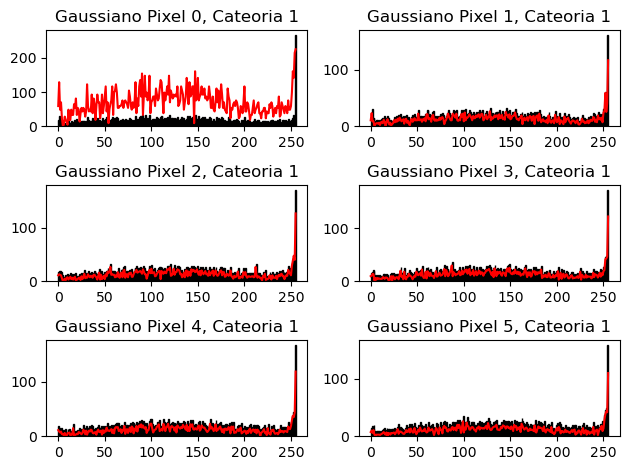

In [36]:
# Creando los histogramas para la categoria 1
fig3, ((gauss1,gauss2),(gauss3,gauss4),(gauss5,gauss6)) = plt.subplots(nrows=3,ncols=2)

# Eje x
x = torch.linspace(0,255,256)

# Ploteando los histogramas
gauss1.hist(x, bins=x, weights=pixel_0_cat1, edgecolor='black')
gauss1.plot(x.numpy(),prob_pixel_0_cat1.numpy(), color='red')
gauss1.set_title('Gaussiano Pixel 0, Cateoria 1')

gauss2.hist(x, bins=x, weights=pixel_1_cat1, edgecolor='black')
gauss2.plot(x.numpy(),prob_pixel_1_cat1.numpy(), color='red')
gauss2.set_title('Gaussiano Pixel 1, Cateoria 1')

gauss3.hist(x, bins=x, weights=pixel_2_cat1, edgecolor='black')
gauss3.plot(x.numpy(),prob_pixel_2_cat1.numpy(), color='red')
gauss3.set_title('Gaussiano Pixel 2, Cateoria 1')

gauss4.hist(x, bins=x, weights=pixel_3_cat1, edgecolor='black')
gauss4.plot(x.numpy(),prob_pixel_3_cat1.numpy(), color='red')
gauss4.set_title('Gaussiano Pixel 3, Cateoria 1')

gauss5.hist(x, bins=x, weights=pixel_4_cat1, edgecolor='black')
gauss5.plot(x.numpy(),prob_pixel_4_cat1.numpy(), color='red')
gauss5.set_title('Gaussiano Pixel 4, Cateoria 1')

gauss6.hist(x, bins=x, weights=pixel_5_cat1, edgecolor='black')
gauss6.plot(x.numpy(),prob_pixel_5_cat1.numpy(), color='red')
gauss6.set_title('Gaussiano Pixel 5, Cateoria 1')

fig3.tight_layout()
plt.show()

In [37]:
# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 0
pixel_0_cat2, prob_pixel_0_cat2 = hist_pdf(set_tensor,set_labels,2,0)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 1
pixel_1_cat2, prob_pixel_1_cat2 = hist_pdf(set_tensor,set_labels,2,1)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 2
pixel_2_cat2, prob_pixel_2_cat2 = hist_pdf(set_tensor,set_labels,2,2)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 3
pixel_3_cat2, prob_pixel_3_cat2 = hist_pdf(set_tensor,set_labels,2,3)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 4
pixel_4_cat2, prob_pixel_4_cat2 = hist_pdf(set_tensor,set_labels,2,4)

# Calculo de las funciones de densidad gaussianas y los histogramas, Categoria 2, Pixel 5
pixel_5_cat2, prob_pixel_5_cat2 = hist_pdf(set_tensor,set_labels,2,5)

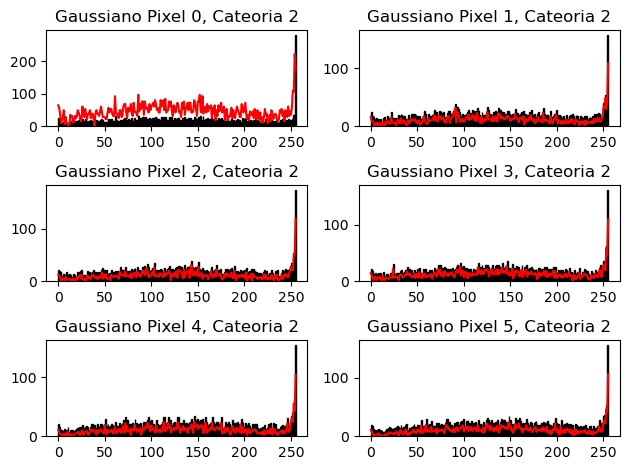

In [38]:
# Creando los histogramas para la categoria 1
fig3, ((gauss1,gauss2),(gauss3,gauss4),(gauss5,gauss6)) = plt.subplots(nrows=3,ncols=2)

# Eje x
x = torch.linspace(0,255,256)

# Ploteando los histogramas
gauss1.hist(x, bins=x, weights=pixel_0_cat2, edgecolor='black')
gauss1.plot(x.numpy(),prob_pixel_0_cat2.numpy(), color='red')
gauss1.set_title('Gaussiano Pixel 0, Cateoria 2')

gauss2.hist(x, bins=x, weights=pixel_1_cat2, edgecolor='black')
gauss2.plot(x.numpy(),prob_pixel_1_cat2.numpy(), color='red')
gauss2.set_title('Gaussiano Pixel 1, Cateoria 2')

gauss3.hist(x, bins=x, weights=pixel_2_cat2, edgecolor='black')
gauss3.plot(x.numpy(),prob_pixel_2_cat2.numpy(), color='red')
gauss3.set_title('Gaussiano Pixel 2, Cateoria 2')

gauss4.hist(x, bins=x, weights=pixel_3_cat2, edgecolor='black')
gauss4.plot(x.numpy(),prob_pixel_3_cat2.numpy(), color='red')
gauss4.set_title('Gaussiano Pixel 3, Cateoria 2')

gauss5.hist(x, bins=x, weights=pixel_4_cat2, edgecolor='black')
gauss5.plot(x.numpy(),prob_pixel_4_cat2.numpy(), color='red')
gauss5.set_title('Gaussiano Pixel 4, Cateoria 2')

gauss6.hist(x, bins=x, weights=pixel_5_cat2, edgecolor='black')
gauss6.plot(x.numpy(),prob_pixel_5_cat2.numpy(), color='red')
gauss6.set_title('Gaussiano Pixel 5, Cateoria 2')

fig3.tight_layout()
plt.show()

### Pregunta 2: Funcion model_gaussian_test

In [39]:
def model_gaussian_test(input_torch,mu_d_k,sigma_d_k, labels_a_priori, num_classes = 10):
    # Haciendo flat el input_torch de entrada
    data_flat = torch.tensor(input_torch.flatten(),dtype=torch.int32)
    
    results_gauss = np.array([])

    for category in range(num_classes):
        # Extraer los Mu y Sigma para la clase en cuestion
        mu_k = mu_d_k[:,category]
        sig_k = sigma_d_k[:,category]

        # Obteniendo la probabilidad gaussiana
        tmp_prob_d_k = prob_gauss_m_t(data_flat,mu_k,sig_k)

        # Para Bayes ingenuo es necesario hacer una multiplicatoria, por lo que se aplica logaritmo natural negativo a los valores de las probabilidad para poder sumarlas
        # Nota: Probalidades iguales a 0 causan un -infinito. Se tienen que sustituir por un numero muy pequenno: 0.00001
        tmp_prob_d_k[tmp_prob_d_k == 0.0] = 0.00001
        tensor_ln_prob_mt = -torch.log(tmp_prob_d_k)
        
        # Se suman todos los valores para tener el score de la categoria para p(m|t=k)
        prob_gauss_mt = tensor_ln_prob_mt.sum()

        # Multiplicar la suma total por la probabilidad a priori del label correspondiente
        prob_t = labels_a_priori[category]
        prob_mt_k = prob_gauss_mt - torch.log(prob_t)

        # Agregar el resultado al arreglo de resultados
        results_gauss = np.append(results_gauss, prob_mt_k)

    # Determinando cual es la categoria correspondiente
    min_value = results_gauss.min()
    category_index = np.where(results_gauss == min_value)

    return category_index[0]

### Pregunta 2: Pruebas unitarias para la funcion model_gaussian_test

In [40]:
%%ipytest

# Creando un set de datos similar al del modelo con histogramas
K = 3
D = 9

# Creando tensor de categorias para 7 set de datos
categories = torch.tensor([0,0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,2,2],[2,2,2],[2,2,2]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

# Calculando las medias y desviaciones estandar
Mu_d_k, Sigma_d_k = train_model_gaussian(categories, data, K, D)

# Calculando las probabilidades a priori de los labels
prob_a_priori = calcular_probabilidad_priori(categories)

def test_model_histogram_testimage_1() -> None:
    # Primera prueba unitaria: Utilizando el tensor [0,2,0],[2,0,2],[0,2,0], el cual tiene que entregar como resultado que pertenece a la categoria #1
    test_image = torch.tensor([[0,2,0],[2,0,2],[0,2,0]])
    category = model_gaussian_test(test_image, Mu_d_k, Sigma_d_k, prob_a_priori, K)
    assert category[0] == 1

def test_model_histogram_testimage_2() -> None:
    # Segunda prueba unitaria: Utilizando el tensor [1,2,1],[1,0,1],[2,1,1], el cual tiene que entregar como resultado que pertenece a la categoria #2 por su semejanza a una de las unidades de entrenamiento
    test_image = torch.tensor([[1,2,1],[1,0,1],[2,1,1]])
    category = model_gaussian_test(test_image, Mu_d_k, Sigma_d_k, prob_a_priori, K)
    assert category[0] == 2

..                                                                                           [100%]
2 passed in 0.02s


### Pregunta 2: Funcion model_batch_gaussian_test

In [41]:
def model_batch_gaussian_test(test_set, test_labels, mu_k, sigma_k, p_t_tensor):
    y_predict_gauss = np.array([])
    
    for element in range(len(test_labels)):
        category_predicted = model_gaussian_test(test_set[element], mu_k, sigma_k, p_t_tensor, len(p_t_tensor))
        y_predict_gauss = np.append(y_predict_gauss,category_predicted[0])
    
    y_gauss_real_tensor = torch.tensor(test_labels,dtype=torch.int32)
    y_gauss_predict_tensor = torch.tensor(y_predict_gauss,dtype=torch.int32)

    # Calculando el Accuracy usando la funcion de scikit-learn
    accuracy = accuracy_score(y_gauss_real_tensor,y_gauss_predict_tensor)
    return accuracy

In [54]:
%%ipytest

# Creando un set de datos similar al del modelo con histogramas
K = 3
D = 9

# Creando tensor de categorias para 7 set de datos
categories = torch.tensor([0,0,1,1,2,2,2])

# Creando tensor de datos: tensores internos de 3x3 para generar 9 unidades. Los valores internos seran aleatorios (no randomizados) para poder realizar el calculo de probabilidades
data = torch.tensor([([1,1,1],[1,1,1],[1,1,1]),([2,2,2],[2,2,2],[2,2,2]),([2,0,2],[0,2,0],[2,0,2]),([0,2,0],[2,0,2],[0,2,0]),([0,0,0],[1,1,1],[2,2,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,1],[0,0,0],[2,2,2])])

# Calculando las medias y desviaciones estandar
Mu_d_k, Sigma_d_k = train_model_gaussian(categories, data, K, D)

# Calculando las probabilidades a priori de los labels
prob_a_priori = calcular_probabilidad_priori(categories)

def test_model_batch_histogram_test_trainingset() -> None:
    # Primera prueba unitaria: Aunque se use el mismo set de entrenamiento, el accuracy es menor a cero porque los valores estan muy cerca entre ellos, pero alrededor del 70%
    accuracy = model_batch_gaussian_test(data, categories, Mu_d_k, Sigma_d_k, prob_a_priori)
    assert accuracy > 0.7

def test_model_batch_histogram_test_randomset() -> None:
    # Segunda prueba unitaria: Si se utiliza un tensor diferente al de entrenamiento, el accuracy debe ser menor a 1
    test_tensor_diff = torch.tensor([([1,0,1],[1,1,0],[0,1,1]),([1,2,1],[1,2,0],[0,1,2]),([2,1,2],[0,2,0],[2,0,1]),([0,2,1],[2,1,2],[1,2,0]),([0,0,1],[1,1,2],[2,0,2]),([2,2,2],[1,1,1],[0,0,0]),([1,1,0],[0,2,0],[1,2,2])])
    accuracy = model_batch_gaussian_test(test_tensor_diff, categories, Mu_d_k, Sigma_d_k, prob_a_priori)
    assert accuracy < 1

..                                                                                           [100%]
2 passed in 0.04s


### Pregunta 2.1: Pruebas del modelo

### Pregunta 1.1: Entrenar el modelo y evaluarlo con el set de pruebas del dataset.

In [57]:
# Creando el set de entrenamiento
training_images_gauss,training_labels_gauss = load_cifar10_dataset()

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


In [44]:
# Creando las variables del modelo gaussiano
K = 10
D = 1024

# Probabilidade de los labels a priori
prob_a_priori_gauss = calcular_probabilidad_priori(training_labels_gauss)

# Entrenando al modelo
Mu_d_k_training, Sigma_d_k_training = train_model_gaussian(training_labels_gauss, training_images_gauss, K, D)

# Evaluando el modelo usando los mismos set de training
accuracy_training_gauss = model_batch_gaussian_test(training_images_gauss, training_labels_gauss, Mu_d_k_training, Sigma_d_k_training, prob_a_priori_gauss)
print(f"El Accuracy del modelo creado con histogramas es de {accuracy_training_gauss * 100}%, al ser evaluado con el set de entrenamiento")

El Accuracy del modelo creado con histogramas es de 11.04%, al ser evaluado con el set de entrenamiento


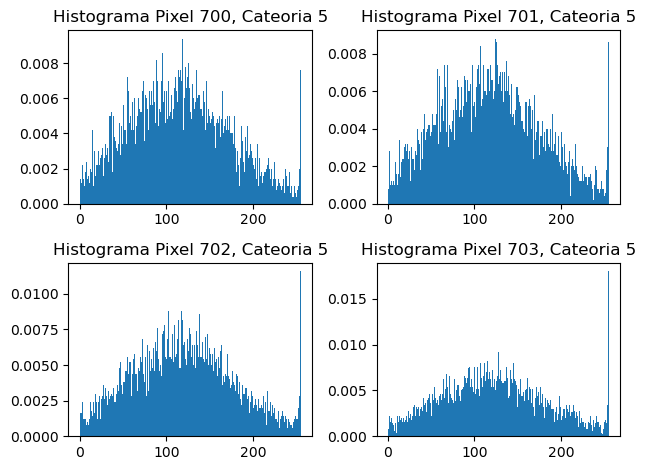

In [69]:
# Creando los histogramas para la categoria 2
fig2, ((hist1,hist2),(hist3,hist4)) = plt.subplots(nrows=2,ncols=2)

# Ploteando los histogramas
hist1.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[5,700,:], histtype='bar')
hist1.set_title('Histograma Pixel 700, Cateoria 5')

hist2.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[5,701,:], histtype='bar')
hist2.set_title('Histograma Pixel 701, Cateoria 5')

hist3.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[5,702,:], histtype='bar')
hist3.set_title('Histograma Pixel 702, Cateoria 5')

hist4.hist(np.arange(0,256), 255, density=True, weights = train_dataset_dens[5,703,:], histtype='bar')
hist4.set_title('Histograma Pixel 703, Cateoria 5')

fig2.tight_layout()
plt.show()

### Pregunta 2.1: Entrenar el modelo y evaluarlo con el set de pruebas del dataset.

In [45]:
# Creando el set de pruebas
test_images,test_labels = load_cifar10_dataset(is_train=False)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])


In [46]:
# El modelo ya habia sido entrenado, por lo tanto, se procede a calcular el accuracy
accuracy_test_gauss = model_batch_gaussian_test(test_images, test_labels, Mu_d_k_training, Sigma_d_k_training, prob_a_priori_gauss)
print(f"El Accuracy del modelo creado con histogramas es de {accuracy_test_gauss*100}%, al ser evaluado con el set de pruebas del dataset")

El Accuracy del modelo creado con histogramas es de 10.5%, al ser evaluado con el set de pruebas del dataset


### Pregunta 2.1: Entrenar el modelo y evaluarlo con el set de training divido en 70% de entrenamiento y 30% de prueba

In [47]:
# Creando los set de entrenamiento y prueba usando las funciones de scikit-learn
images_train, images_test, labels_train, labels_test = train_test_split(training_images,training_labels,test_size=0.3)

In [48]:
# Ahora se comprueba que el sampling se haya hecho de forma de correcta
print("Train images shape ", images_train.shape)
print("Train labels shape", labels_train.shape)

Train images shape  torch.Size([35000, 1, 32, 32])
Train labels shape torch.Size([35000])


In [49]:
# Tambien se comprueba que las dimensiones de los tensores de pruebas esten correctos
print("Test images shape ", images_test.shape)
print("Test labels shape", labels_test.shape)

Test images shape  torch.Size([15000, 1, 32, 32])
Test labels shape torch.Size([15000])


In [50]:
# Creando las variables del hypercubo
K = 10
D = 1024

# Creando Dataframe para almacenar los resultados
df_acc_results_gauss = pd.DataFrame(columns=['Cycle','Accuracy'])

# Tasa de acierto para 30 repeticiones, haciendo diferentes particiones cada vez
for cycle in range(30):
    # Nuevo slip para entrenamiento y prueba
    images_train, images_test, labels_train, labels_test = train_test_split(training_images,training_labels,test_size=0.3)

    # Probabilidade de los labels a priori
    prob_a_priori_gauss = calcular_probabilidad_priori(labels_train)

    # Entrenando al modelo
    Mu_d_k, Sigma_d_k = train_model_gaussian(labels_train, images_train, K, D)

    # Evaluando el modelo
    accuracy_gauss = model_batch_gaussian_test(test_images, test_labels, Mu_d_k_training, Sigma_d_k_training, prob_a_priori_gauss)

    # Populando el dataframe con cada ciclo
    df_acc_results_gauss.loc[len(df_acc_results_gauss.index)] = [cycle + 1,accuracy_gauss * 100]

# Verficando los resultados obtenidos
print(df_acc_results_gauss)

    Cycle  Accuracy
0     1.0     10.52
1     2.0     10.51
2     3.0     10.49
3     4.0     10.52
4     5.0     10.51
5     6.0     10.52
6     7.0     10.55
7     8.0     10.49
8     9.0     10.49
9    10.0     10.50
10   11.0     10.50
11   12.0     10.53
12   13.0     10.52
13   14.0     10.51
14   15.0     10.53
15   16.0     10.51
16   17.0     10.50
17   18.0     10.51
18   19.0     10.49
19   20.0     10.50
20   21.0     10.51
21   22.0     10.51
22   23.0     10.50
23   24.0     10.52
24   25.0     10.50
25   26.0     10.51
26   27.0     10.51
27   28.0     10.51
28   29.0     10.51
29   30.0     10.50


In [51]:
# Calculando la media y la desviacion estandar de las tasas de acierto
tasa_aciertos_gauss = df_acc_results_gauss['Accuracy'].to_numpy()

media_aciertos_gauss = np.mean(tasa_aciertos_gauss)
std_aciertos_gauss = np.std(tasa_aciertos_gauss)

print(f"La media de la tasa de aciertos es de {round(media_aciertos_gauss,3)}%, y la desviacion estandar es de {round(std_aciertos_gauss,3)}%")

La media de la tasa de aciertos es de 10.509%, y la desviacion estandar es de 0.013%
